In [ ]:
# Let's visualize the relationships between embeddings of abstracts for different 
# math categories of arxiv articles.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json('C:/dev/arxiv-search/data/total/arxiv-metadata.json', lines=True)

In [4]:
categories = [ "math.AG", "math.AT", "math.AP", "math.CT", "math.CA", "math.CO",
               "math.AC", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM",
               "math.GN", "math.GT", "math.GR", "math.HO", "math.IT", "math.KT",
               "math.LO", "math.MP", "math.MG", "math.NT", "math.NA", "math.OA",
               "math.OC", "math.PR", "math.QA", "math.RT", "math.RA", "math.SP",
               "math.ST", "math.SG" ]

In [5]:
# The categories field is a string with category words separated by spaces. Each category word 
# for a math category is in the form 'math.XY'.
def isMathArticle(string):
    return string[0:5] == "math."

def primaryMathCat(string):
    return string.split()[0]

In [6]:
cat_indices = {}
for cat in categories:
    dfcat = df.loc[df['categories'].map(primaryMathCat) == cat]
    cat_indices[cat] = np.array(dfcat.index)
cat_indices['math.AG'].shape

(32107,)

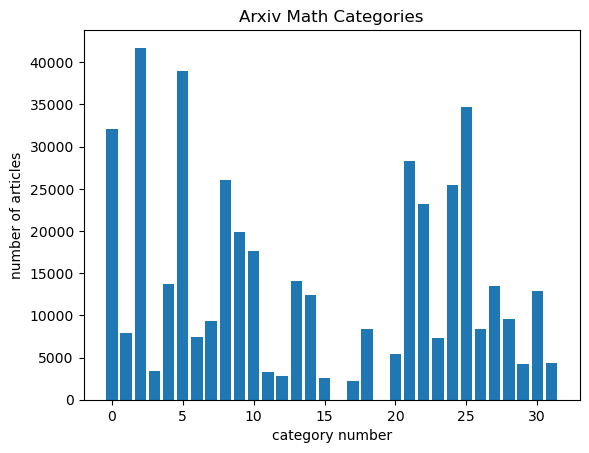

In [7]:
cat_counts = [cat_indices[cat].shape[0] for cat in categories]
fig, ax = plt.subplots()
ax.bar(range(len(categories)), cat_counts)
ax.set_xlabel('category number')
ax.set_ylabel('number of articles')
ax.set_title('Arxiv Math Categories')
plt.show()

In [63]:
for j in range(len(categories)):
    print(f"Category {j}: {categories[j]} has {cat_counts[j]} articles")

Category 0: math.AG has 32107 articles
Category 1: math.AT has 7870 articles
Category 2: math.AP has 41724 articles
Category 3: math.CT has 3416 articles
Category 4: math.CA has 13733 articles
Category 5: math.CO has 38910 articles
Category 6: math.AC has 7397 articles
Category 7: math.CV has 9389 articles
Category 8: math.DG has 25987 articles
Category 9: math.DS has 19860 articles
Category 10: math.FA has 17634 articles
Category 11: math.GM has 3265 articles
Category 12: math.GN has 2865 articles
Category 13: math.GT has 14025 articles
Category 14: math.GR has 12441 articles
Category 15: math.HO has 2522 articles
Category 16: math.IT has 0 articles
Category 17: math.KT has 2278 articles
Category 18: math.LO has 8425 articles
Category 19: math.MP has 0 articles
Category 20: math.MG has 5438 articles
Category 21: math.NT has 28332 articles
Category 22: math.NA has 23188 articles
Category 23: math.OA has 7330 articles
Category 24: math.OC has 25442 articles
Category 25: math.PR has 3473

In [64]:
# Can we isolate pairs of categories from each other with clustering?
abstract_embeddings = np.load('C:/dev/arxiv-search/data/total/normalized-abstract-embeddings-msmarco.npy')
cat_embeddings = {cat:abstract_embeddings[cat_indices[cat]] for cat in categories}

In [65]:
import faiss

# Concatenates the embeddings of cat1 and cat2.
def pair_embedding(cat1, cat2):
    return np.append(cat_embeddings[cat1], cat_embeddings[cat2], axis=0)

# Returns the indices / positions of the centroids generated from the concatenation of embeddings of cat1 and cat2
def cluster_indices_centroids(cat1, cat2, n_clusters):
    kmeans = faiss.Kmeans(384, n_clusters, niter=50, verbose=True)
    pair_embs = pair_embedding(cat1, cat2)
    kmeans.train(pair_embs)
    D, I = kmeans.index.search(pair_embs, 1)
    return I, kmeans.centroids

cluster_indices_centroids("math.AG", "math.PR", 2)

(array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=int64),
 array([[-7.39245787e-02, -2.11479738e-02, -4.24455926e-02,
         -2.35527176e-02, -3.85609455e-02, -1.15436185e-02,
         -3.32795568e-02, -1.08524878e-02,  2.53159981e-02,
         -4.55340892e-02,  5.62486276e-02,  1.42513923e-02,
          3.66634130e-02, -1.45757478e-02,  5.17642545e-03,
          2.52232719e-02, -6.33484870e-02,  1.68396104e-02,
          5.10035269e-02,  7.44561665e-03,  1.04256943e-02,
         -4.81633022e-02, -3.42624933e-02, -3.23661184e-03,
          4.11559781e-03,  2.44729035e-02,  4.04451303e-02,
         -3.48058306e-02,  5.47684729e-02, -5.25603592e-02,
          4.16095220e-02,  8.60261638e-03, -2.76817568e-02,
         -9.58039891e-03,  3.93991470e-02, -9.70781874e-03,
          3.85306440e-02,  1.15949241e-03,  3.88886109e-02,
          2.97979005e-02,  3.18642743e-02,  6.77787000e-03,
         -1.58694573e-02, -2.10062545e-02,  1.20619712

In [17]:
from sklearn.decomposition import PCA
# Gets first dim-many principal components of embeddings of the concatenation of cat1 and cat2 embeddings.
def pcaProj(cat1, cat2, dim):
    pca = PCA(n_components=dim)
    pair_emb = pair_embedding(cat1, cat2)
    pca.fit(pair_emb)
    return pca.transform(pair_emb)

pcaProj("math.AG", "math.PR", 2)

array([[ 0.02559466,  0.02854396],
       [ 0.1353584 , -0.03717388],
       [ 0.39606625,  0.00813494],
       ...,
       [-0.03486128, -0.14739317],
       [-0.20217192, -0.03319784],
       [-0.05440024,  0.08086873]], dtype=float32)

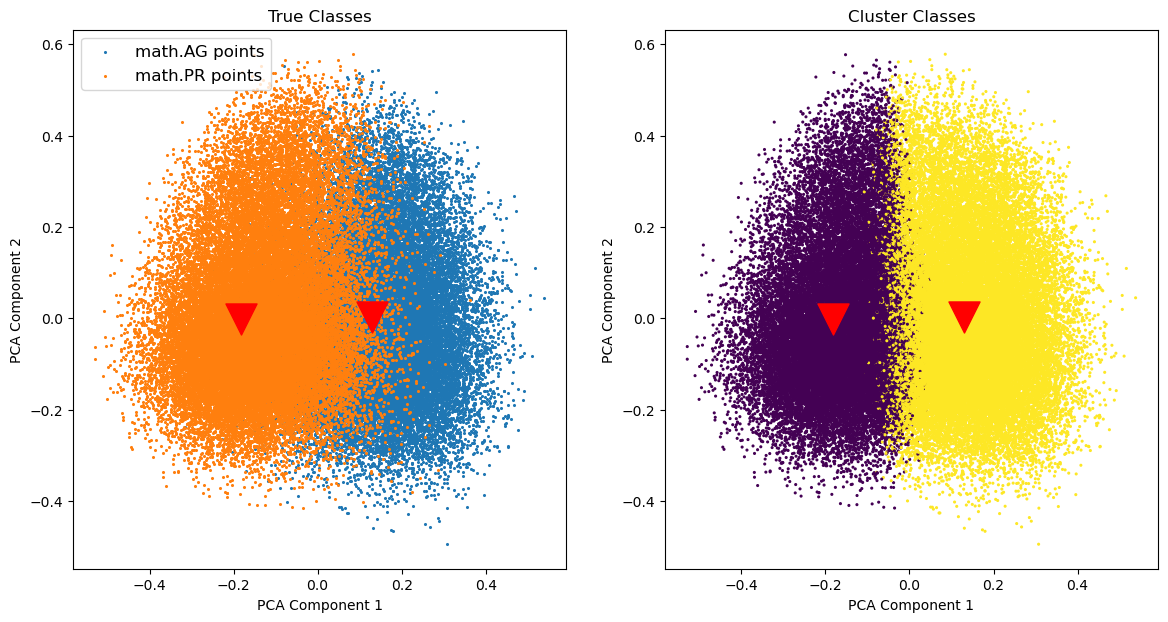

In [95]:
# Makes a scatterplot comparing clustering of cat1 and cat2 with the true classification
# by first performing clustering then projecting results to the first two principal components.
def cluster_plot(cat1, cat2, n_clusters):
    I, centroids = cluster_indices_centroids(cat1, cat2, n_clusters)
    pca2 = PCA(n_components=2)
    pair_emb = pair_embedding(cat1, cat2)
    pca2.fit(pair_emb)
    lowdim_cat_emb = pca2.transform(pair_emb)
    lowdim_cent_emb = pca2.transform(centroids)

    cat1_len = cat_indices[cat1].shape[0]
    cat2_len = cat_indices[cat2].shape[0]
    x1, y1 = lowdim_cat_emb[:cat1_len,0], lowdim_cat_emb[:cat1_len,1]
    x2, y2 = lowdim_cat_emb[cat1_len:,0], lowdim_cat_emb[cat1_len:,1]
    centroid_x, centroid_y = lowdim_cent_emb[:,0], lowdim_cent_emb[:,1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

    ax1.scatter(x1, y1, s=1.5, label=f"{cat1} points")
    ax1.scatter(x2, y2, s=1.5, label=f"{cat2} points")
    ax1.scatter(centroid_x, centroid_y, s=500, color='red', marker='v')
    ax1.set_title('True Classes')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.legend(loc='upper left', fontsize=12)
    
    x, y = lowdim_cat_emb[:,0], lowdim_cat_emb[:,1]
    ax2.scatter(x, y, c=I, s=1.5)
    ax2.scatter(centroid_x, centroid_y, s=500, color='red', marker='v')
    ax2.set_title('Cluster Classes')
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    
    plt.show()

cluster_plot("math.AG", "math.PR", 2)

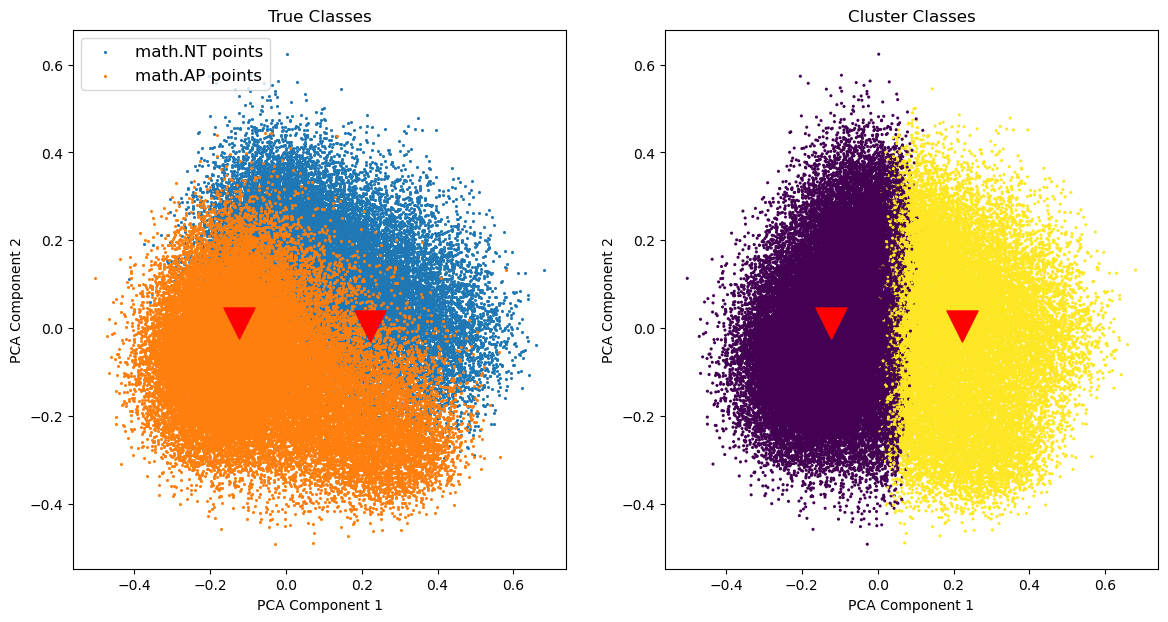

In [96]:
cluster_plot("math.NT", "math.AP", 2)

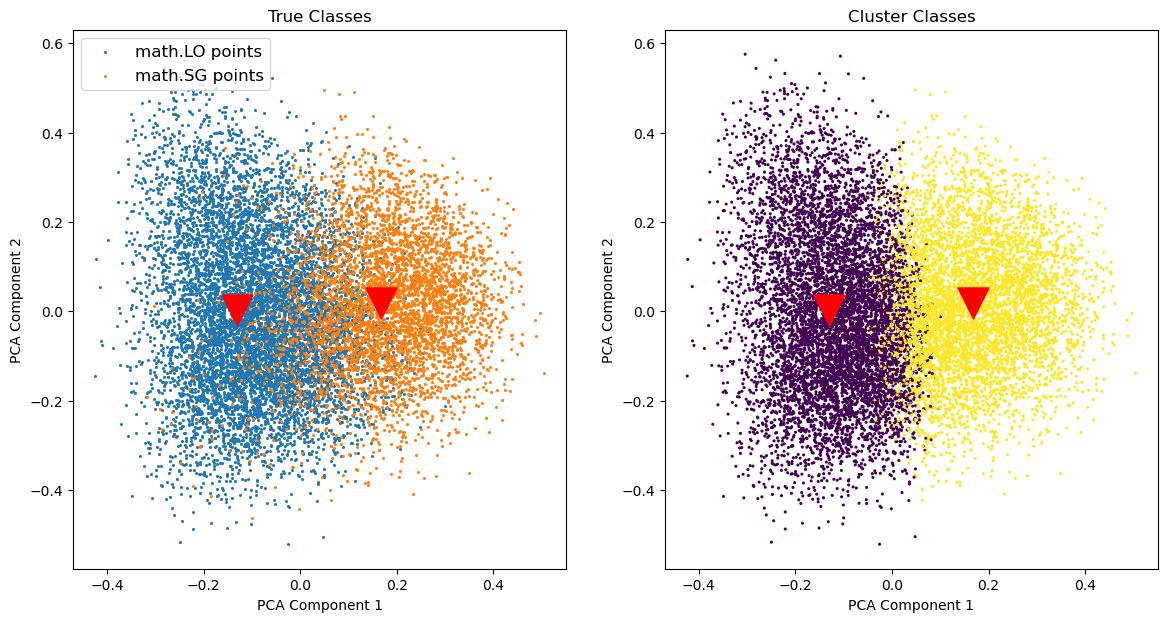

In [97]:
cluster_plot("math.LO", "math.SG", 2)

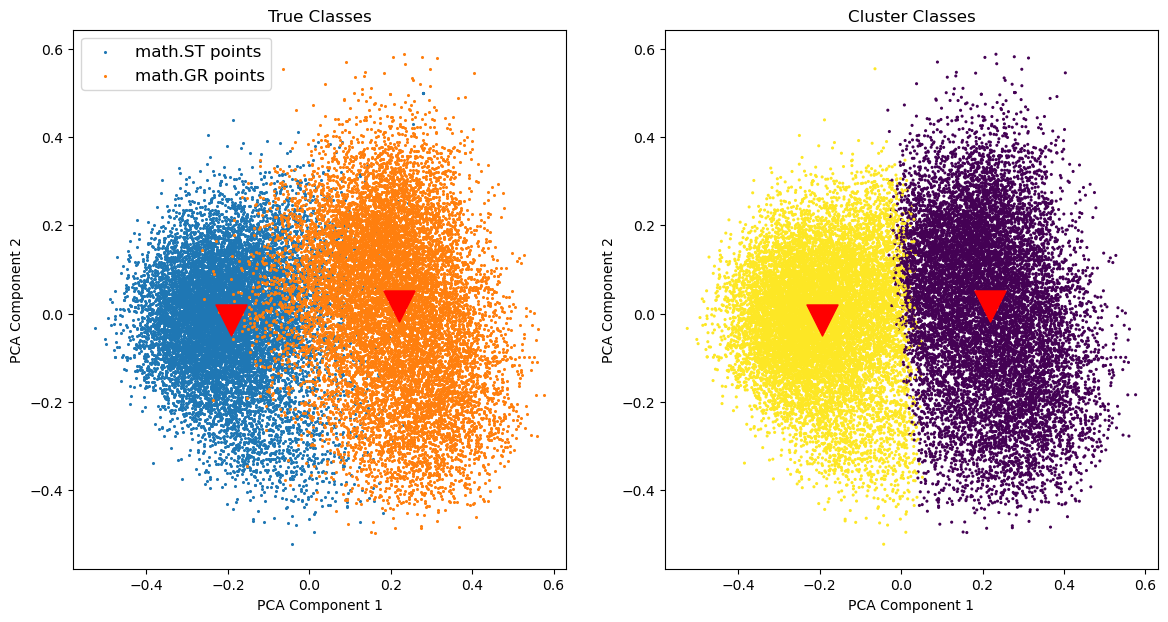

In [98]:
cluster_plot("math.ST", "math.GR", 2)

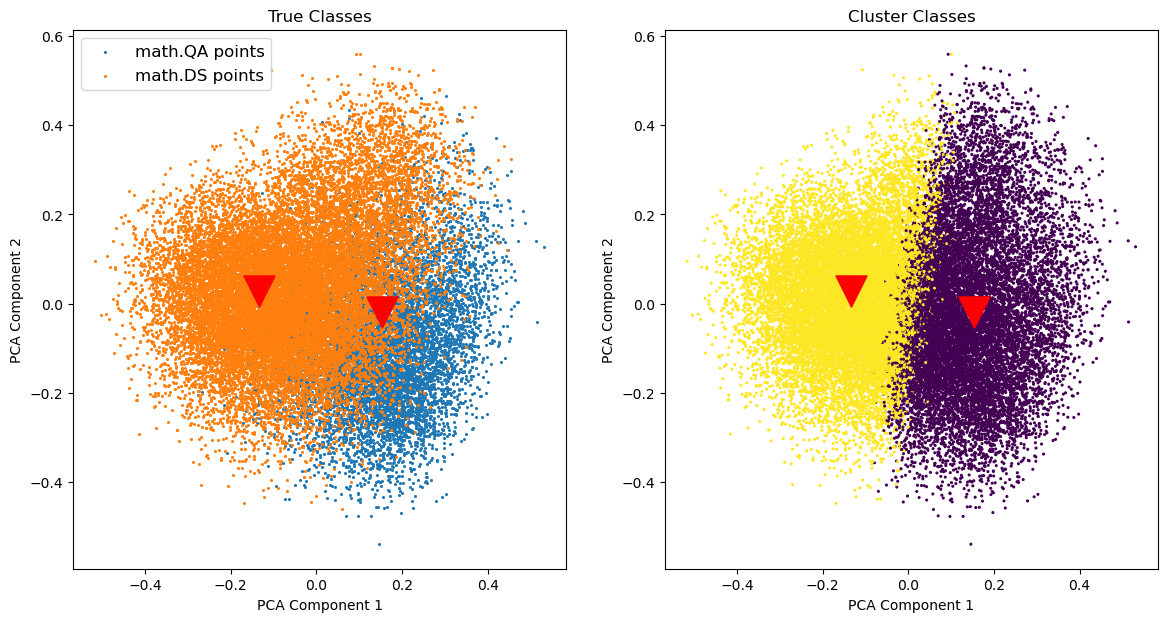

In [100]:
cluster_plot("math.QA", "math.DS", 2)

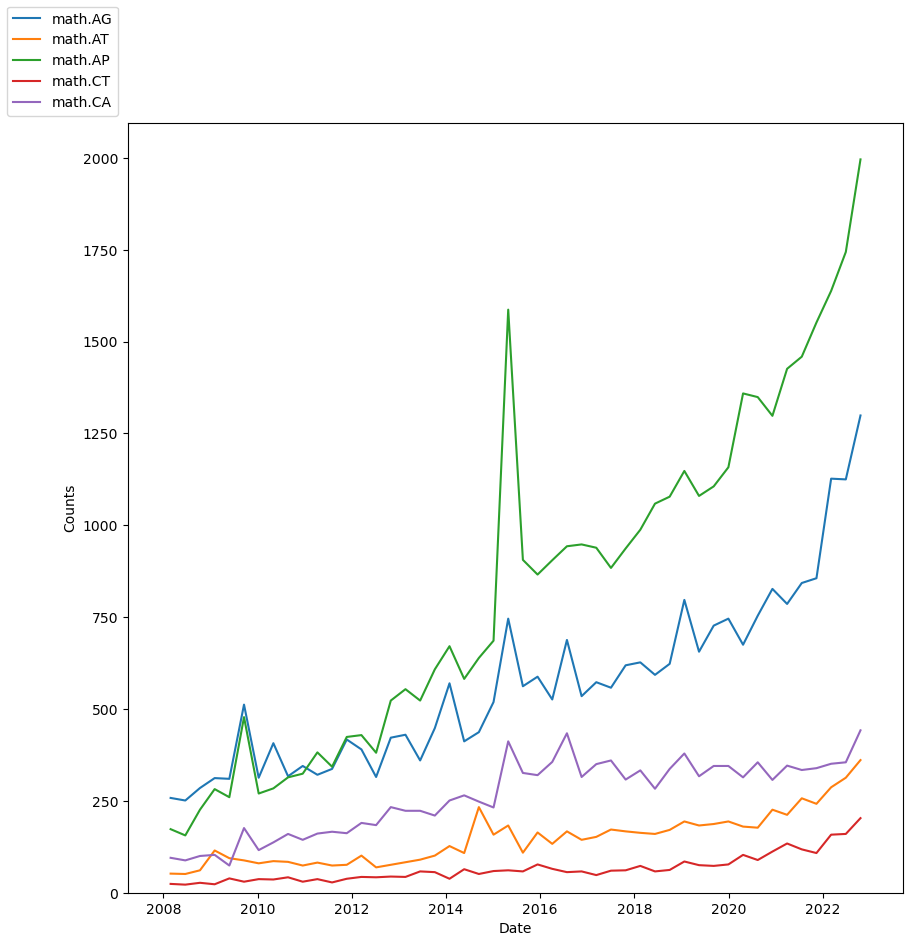

In [142]:
# Visualizes article counts over time for different categories.
import datetime as dt
start = dt.datetime(2008,1,1)
end = dt.datetime.now()

def create_datetime(pre_date):
    return dt.datetime.strptime(pre_date, '%Y-%m-%d')

def count_over_time_plot(categories):
    fig, ax = plt.subplots(figsize=(10,10))
    for cat in categories:
        catdf = df.loc[df['categories'].map(primaryMathCat) == cat]
        catdf = catdf['update_date'].apply(create_datetime)
        counts, x, _ = plt.hist(catdf.values, bins=48, color='white', range=(start, catdf.values.max()))
        centers = 0.5 * (x[1:] + x[:-1])
        plt.plot(centers, counts, label=cat)
    fig.legend(loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Counts')
    plt.show()

count_over_time_plot(categories[0:5])